# Import

In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# Load Data

In [2]:
train_data = pickle.load(open('new_train.pkl','rb'))
valid_data = pickle.load(open('new_test.pkl','rb'))

# Data Statistics

In [3]:
unique_values_distribution = []
def unique_col_values(df):
    for column in df:
        unique_values_distribution.append ((df[column].name, len(df[column].unique()), df[column].dtype ))
        
unique_col_values(train_data)

columns_heading  = ['Header Name','Unique Count','Data Type']

data_distribution = pd.DataFrame.from_records(unique_values_distribution, columns=columns_heading)

In [4]:
data_distribution

,Header Name,Unique Count,Data Type
0,id,2400,int64
1,spacegroup,6,int64
2,number_of_total_atoms,6,float64
3,percent_atom_al,42,float64
4,percent_atom_ga,42,float64
5,percent_atom_in,42,float64
6,lattice_vector_1_ang,1288,float64
7,lattice_vector_2_ang,1216,float64
8,lattice_vector_3_ang,1210,float64
9,lattice_angle_alpha_degree,457,float64


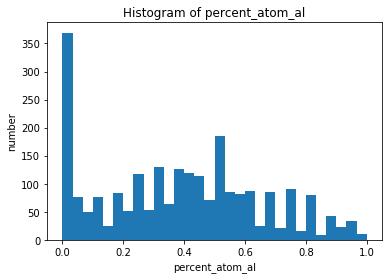

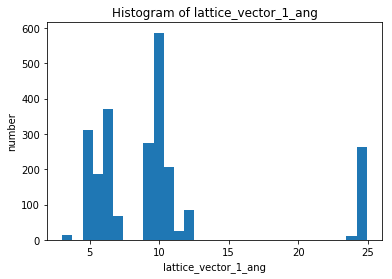

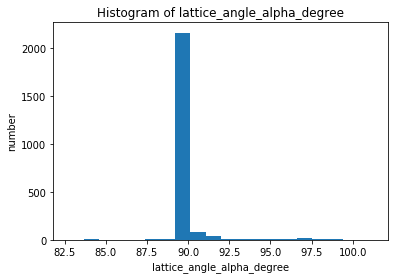

In [5]:
space_groups_data = np.array(train_data['percent_atom_al'])
plt.hist(space_groups_data,bins=30)
plt.title("Histogram of percent_atom_al")
plt.xlabel("percent_atom_al")
plt.ylabel("number")
plt.show()

space_groups_data = np.array(train_data['lattice_vector_1_ang'])
plt.hist(space_groups_data,bins=30)
plt.title("Histogram of lattice_vector_1_ang")
plt.xlabel("lattice_vector_1_ang")
plt.ylabel("number")
plt.show()

space_groups_data = np.array(train_data['lattice_angle_alpha_degree'])
plt.title("Histogram of lattice_angle_alpha_degree")
plt.xlabel("lattice_angle_alpha_degree")
plt.ylabel("number")
plt.hist(space_groups_data,bins=20)
plt.show()

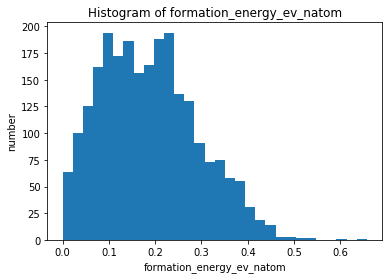

In [6]:
formation_energy_data = np.array(train_data['formation_energy_ev_natom'])
plt.hist(formation_energy_data,bins=30)
plt.title("Histogram of formation_energy_ev_natom")
plt.xlabel("formation_energy_ev_natom")
plt.ylabel("number")
plt.show()

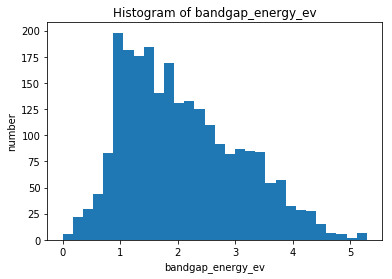

In [7]:
bandgap_energy_data = np.array(train_data['bandgap_energy_ev'])
plt.title("Histogram of bandgap_energy_ev")
plt.xlabel("bandgap_energy_ev")
plt.ylabel("number")
plt.hist(bandgap_energy_data,bins=30)
plt.show()

# Extract Useful Data

In [8]:
X_train = train_data.drop(["id","formation_energy_ev_natom","bandgap_energy_ev"],axis=1)
Y_formation = train_data["formation_energy_ev_natom"]
Y_bandgap = train_data["bandgap_energy_ev"]

# Split for Different Tasks

In [9]:
formation_X_train, formation_X_test, formation_Y_train, formation_Y_test = train_test_split(X_train,Y_formation,test_size=0.25,random_state=23)
bandgap_X_train, bandgap_X_test, bandgap_Y_train, bandgap_Y_test = train_test_split(X_train,Y_bandgap,test_size=0.25,random_state=23)

# Set up Model

In [10]:
import time
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, RANSACRegressor
from xgboost.sklearn import XGBRegressor

In [11]:
adb = AdaBoostRegressor()
gbt = GradientBoostingRegressor()
xgb = XGBRegressor()
rf = RandomForestRegressor()

models = {'ABR':adb,
         'ABR_auto':adb,
         'GBT': gbt,
         'GBT_auto': gbt,
         'XGB': xgb,
         'XGB_auto': xgb,
         'RF':rf}

configure parameters

In [25]:
def hyper_parameters(name):
    if name=='ABR':
        params = {
            'adaboostregressor__n_estimators': [50,200,500],
            'adaboostregressor__loss': ['exponential'],
            'adaboostregressor__learning_rate': [0.05,0.1],
            'adaboostregressor__n_estimators': [500]
        }
    elif name=='ABR_auto':
        params = {}
    elif name=='GBT':
        params = {
            'gradientboostingregressor__n_estimators': [200,500],
            'gradientboostingregressor__learning_rate': [0.05,0.1],
            'gradientboostingregressor__max_depth': [3,9,12]
        }
    elif name=='GBT_auto':
        params = {}
    elif name=='XGB':
        params = {
            'xgbregressor__max_depth': [13],
            'xgbregressor__learning_rate': [0.1],
            'xgbregressor__n_estimators': [80,500],
            'xgbregressor__reg_lambda': [0.5],
            'xgbregressor__max_delta_step': [0.3]
        }
    elif name=='XGB_auto':
        params = {}
    elif name=='RF':
        params={}
    
    return params

set up criteria

In [26]:
def rmsle(pred,target):
    return np.sqrt(np.square(np.log(pred + 1) - np.log(target + 1)).mean())
def error_info(pred, target):
    meansquare_error = mean_squared_error(pred, target)
    r2square_error = r2_score(pred, target)
    rmslog_error = rmsle(pred, target)
    return (meansquare_error, r2square_error, rmslog_error)

define pipeline process

In [27]:
formation_train_reg = []          
formation_test_error_scores = []
bandgap_train_reg = []          
bandgap_test_error_scores = []
    
def predict_evaluate(x_train, y_train, x_test, y_test, train_reg, test_error_scores):  
    print (" Start ")
    t = time.time()
    for i, model in models.items():
       
        pipe = make_pipeline(preprocessing.StandardScaler(), model)
        hyperparameters = hyper_parameters(i)
        model_opt = GridSearchCV(pipe, hyperparameters, cv=15)
    
        # Fit and predict train data
        model_opt.fit(x_train, y_train)
        
        print (i,' trained best score :: ',model_opt.best_score_)
        
        #print (i,' - ',trainedclfs.best_params_)
        
        # predict test data
        pred_test = model_opt.predict(x_test)
        
        # Get error scores on test data
        mse, r2, rmsle = error_info(y_test, pred_test)

        test_error_scores.append ((i,  mse, r2, rmsle))
        train_reg.append ((i, model_opt))
        
    print (" Training Completed ! ")    
    print (" Total training time :  ({0:.3f} s)\n".format(time.time() - t) )
    return ( test_error_scores, train_reg)
    
def error_table (score, labels, sort_col ):
    #labels  = ['Clf','mean absolute error','mean square error','R2 squared', 'Mean Sq Log Error', 'Root Mean Sq Log Error']
    scored_df = pd.DataFrame.from_records(score, columns=labels, index = None)
    sorted_scored = scored_df.sort_values(by = sort_col, ascending=True)
    return sorted_scored

# Formation Energy

In [28]:
form_error_scores, trained_pred_form = predict_evaluate(formation_X_train, formation_Y_train, 
                                                        formation_X_test, formation_Y_test, 
                                                        formation_train_reg, formation_test_error_scores)

 Start 
ABR  trained best score ::  0.7063387318543534
ABR_auto  trained best score ::  0.7012000311941503
GBT  trained best score ::  0.8427379218337664
GBT_auto  trained best score ::  0.840506253182015
XGB  trained best score ::  0.8174545060342711
XGB_auto  trained best score ::  0.839926802611108
RF  trained best score ::  0.8309745380018564
 Training Completed ! 
 Total training time :  (740.303 s)



In [29]:
labels  = ['Models','MSE', 'R Squared', 'RMSLE']
print("Formation Energy scores : on test data - ordered by Mean Square Error : \n")
error_table(form_error_scores, labels,'MSE')

Formation Energy scores : on test data - ordered by Mean Square Error : 



,Models,MSE,R Squared,RMSLE
5,XGB_auto,0.001794,0.834227,0.033912
3,GBT_auto,0.001834,0.830512,0.034290
6,RF,0.001880,0.826223,0.034539
2,GBT,0.001892,0.825165,0.034793
4,XGB,0.002027,0.812633,0.035854
1,ABR_auto,0.003078,0.715555,0.046529
0,ABR,0.003249,0.699739,0.047807


# Bandgap Energy

In [ ]:
bandgap_error_scores, trained_pred_bandgap = predict_evaluate(bandgap_X_train, bandgap_Y_train, 
                                                              bandgap_X_test, bandgap_Y_test,
                                                              bandgap_train_reg, bandgap_test_error_scores)

 Start 
ABR  trained best score ::  0.8844422352899749
ABR_auto  trained best score ::  0.8791290069335246
GBT  trained best score ::  0.9475250533625043
GBT_auto  trained best score ::  0.9456528499902109


In [ ]:
labels  = ['Models','MSE', 'R Squared', 'RMSLE']
print("Bandgap Energy scores : on test data - ordered by Mean Square Error : \n")
error_table(bandgap_error_scores, labels,'MSE')

# Final Test Prediction for Kaggle Submmit

In [ ]:
test_data = pickle.load(open('new_test.pkl','rb'))
test_data = test_data.drop(["id"],axis=1)

In [ ]:
formation_submit = formation_train_reg[-1][1].predict(test_data)
bandgap_submit = bandgap_train_reg[3][1].predict(test_data)
idx = np.array([a for a in range(1,len(formation_submit)+1)])

In [ ]:
sub_data = np.stack((idx,formation_submit,bandgap_submit)).T

In [ ]:
sub_df = pd.DataFrame(sub_data,columns=["id","formation_energy_ev_natom","bandgap_energy_ev"])
sub_df["id"] = sub_df["id"].astype("int")
sub_df.set_index("id")
sub_df.to_csv("sub_5_31_2018.csv",index=False)